In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_fscore_support as score
from sklearn.linear_model import LogisticRegression

In [2]:
resultsDF=pd.read_csv("results.csv")
rankingDF=pd.read_csv('fifa_rankings.csv')
fixturesDF=pd.read_csv("fixtures.csv")

## Data Exploration

In [3]:
#update winner column
def updateWinnerTeam(resultsDF):
    winner = []
    for i in range (len(resultsDF)):
        match=resultsDF.iloc[i]
        if (match['home_score'] > match['away_score']):
            winner.append(match['home_team'])
        elif (match['home_score'] < match['away_score']):
            winner.append(match['away_team'])
        else:
            winner.append('Draw')
    return winner

resultsDF['winning_team'] = updateWinnerTeam(resultsDF)

In [4]:
#update goal difference column
def updateGoalDiffrence(resultsDF):
    return abs(resultsDF['home_score'] - resultsDF['away_score'])

resultsDF['goal_difference'] = updateGoalDiffrence(resultsDF)

In [5]:
def updateMatchYear(resultsDF):
    year = []
    for row in resultsDF['date']:
        year.append(int(row[:4]))
    return year

resultsDF ['match_year']= updateMatchYear(resultsDF)
    

In [6]:
#lets work with a subset of the data one that includes games played by Nigeria in a Nigeria dataframe
def exploreTeam(teamName):
    teamDF= resultsDF[(resultsDF['home_team'] == teamName) | (resultsDF['away_team'] == teamName)]
    teamWorldCupMatchesDF = teamDF[teamDF.match_year >= 1930]
    wins = []
    for match in teamWorldCupMatchesDF['winning_team']:
        if ((match != teamName) and (match != 'Draw')):
            wins.append('Loss')
        else: #other team wins
            wins.append(match)
    winsDF= pd.DataFrame(wins, columns=['results'])
    visualizeResults(winsDF)

In [7]:
def visualizeResults(stats):
    loss=len(stats[stats.results=='Loss'])
    draw=len(stats[stats.results=='Draw'])
    labels = ['Loss', 'Draw', 'Win']
    sizes = [loss, draw, len(stats)-(loss+draw)]
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

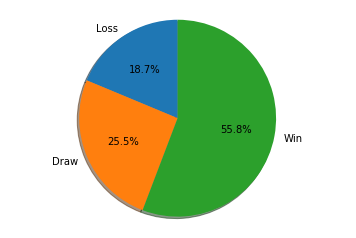

In [8]:
exploreTeam("England")

## Preparing World Cup 2018 Data

In [9]:
worldcup_teams = ['Australia', ' Iran', 'Japan', 'Korea Republic', 
            'Saudi Arabia', 'Egypt', 'Morocco', 'Nigeria', 
            'Senegal', 'Tunisia', 'Costa Rica', 'Mexico', 
            'Panama', 'Argentina', 'Brazil', 'Colombia', 
            'Peru', 'Uruguay', 'Belgium', 'Croatia', 
            'Denmark', 'England', 'France', 'Germany', 
            'Iceland', 'Poland', 'Portugal', 'Russia', 
            'Serbia', 'Spain', 'Sweden', 'Switzerland']
df_teams_home = resultsDF[resultsDF['home_team'].isin(worldcup_teams)]
df_teams_away = resultsDF[resultsDF['away_team'].isin(worldcup_teams)]
worldCupTeamsResultsDF = pd.concat((df_teams_home, df_teams_away))
worldCupTeamsResultsDF.drop_duplicates()
worldCupTeamsResultsDF=worldCupTeamsResultsDF[worldCupTeamsResultsDF['match_year']>=1930][['home_team','away_team','winning_team']]

In [10]:
worldCupTeamsResultsDF = worldCupTeamsResultsDF.reset_index(drop=True)
worldCupTeamsResultsDF.loc[worldCupTeamsResultsDF.winning_team == worldCupTeamsResultsDF.home_team,'winning_team']=1
worldCupTeamsResultsDF.loc[worldCupTeamsResultsDF.winning_team == 'Draw', 'winning_team']=0
worldCupTeamsResultsDF.loc[worldCupTeamsResultsDF.winning_team == worldCupTeamsResultsDF.away_team, 'winning_team']=-1

## Building Model

In [11]:
contData = pd.get_dummies(worldCupTeamsResultsDF, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Separate X and y sets
X = contData.drop(['winning_team'], axis=1)
y = contData["winning_team"]
y = y.astype('int')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [13]:
#Logistic Regression
clf = LogisticRegression()
clf.fit(X_train,y_train)
predicted=clf.predict(X_test)

precision, recall, fscore, support = score(y_test, predicted, average='micro')

print('F-1 Score = {}'.format(fscore.mean()))

F-1 Score = 0.5525132815692685


In [14]:
# Create new columns with ranking position of each team
fixturesDF.insert(1, 'firstTeamRank', fixturesDF['Home Team'].map(rankingDF.set_index('Team')['Position']))
fixturesDF.insert(2, 'secondTeamRank', fixturesDF['Away Team'].map(rankingDF.set_index('Team')['Position']))

In [15]:
#fixturesDF.first_position.astype(int)
# We only need the group stage games, so we have to slice the dataset
fixturesDF = fixturesDF.iloc[:48, :]
fixturesDF.tail()

,Round Number,firstTeamRank,secondTeamRank,Date,Location,Home Team,Away Team,Group,Result
43,3,6.0,25.0,27/06/2018 21:00,Nizhny Novgorod Stadium,Switzerland,Costa Rica,Group E,NaN
44,3,60.0,10.0,28/06/2018 17:00,Volgograd Stadium,Japan,Poland,Group H,NaN
45,3,28.0,16.0,28/06/2018 17:00,Samara Stadium,Senegal,Colombia,Group H,NaN
46,3,55.0,14.0,28/06/2018 21:00,Saransk Stadium,Panama,Tunisia,Group G,NaN
47,3,13.0,3.0,28/06/2018 21:00,Kaliningrad Stadium,England,Belgium,Group G,NaN


In [16]:
#set ranking based on teams
newPredictionsDF=pd.DataFrame()
for i in range(len(fixturesDF)):
    match=fixturesDF.iloc[i]
    if match['firstTeamRank'] < match['secondTeamRank']:
        newPredictionsDF=newPredictionsDF.append({'home_team': match['Home Team'], 'away_team': match['Away Team'], 'winning_team': None},ignore_index=True)
    else:
        newPredictionsDF=newPredictionsDF.append({'home_team': match['Away Team'], 'away_team': match['Home Team'], 'winning_team':None},ignore_index=True)
fixturesDF=pd.DataFrame(newPredictionsDF)
newPredictionsDF.drop(columns=['winning_team'],inplace=True)

In [17]:
# Get dummy variables and drop winning_team column
newPredictionsDF = pd.get_dummies(newPredictionsDF, prefix=['away_team','home_team'], columns=['away_team','home_team'])

# Add missing columns compared to the model's training dataset
missing_cols = set(contData.columns) - set(newPredictionsDF.columns)
for c in missing_cols:
    newPredictionsDF[c] = 0
newPredictionsDF = newPredictionsDF[contData.columns]
newPredictionsDF.drop(columns=['winning_team'],inplace=True)

In [18]:
#group matches 
def predictResult(newPredictionsDF):
    winners=[]
    newPredcts = clf.predict_proba(newPredictionsDF)
    for i in range(len(fixturesDF)):
        home=fixturesDF.iloc[i]["home_team"]
        away=fixturesDF.iloc[i]["away_team"]
        maxProb=list(newPredcts[i]).index(max(newPredcts[i]))
        print(home + " and " + away )
    #     print(newPredcts[i])
    #     print(maxProb)
        if (maxProb == 0):
            print("Winner: " +away + "\nby %"+str(max(newPredcts[i])))
            winners.append(away)
        elif (maxProb == 1):
            print("Draw\nby % "+str(max(newPredcts[i])))
            winners.append("Draw")
        elif (maxProb == 2):
            print("Winner: " + home +"\nby % "+str(max(newPredcts[i])))
            winners.append(home)
        print('-'*50)
    return winners 

In [19]:
fixturesDF['winning_team']=predictResult(newPredictionsDF)

Russia and Saudi Arabia
Winner: Russia
by % 0.675571787487
--------------------------------------------------
Uruguay and Egypt
Winner: Uruguay
by % 0.580528692986
--------------------------------------------------
Iran and Morocco
Draw
by % 0.452824129986
--------------------------------------------------
Portugal and Spain
Winner: Spain
by %0.357572890988
--------------------------------------------------
France and Australia
Winner: France
by % 0.625410442238
--------------------------------------------------
Argentina and Iceland
Winner: Argentina
by % 0.821111421494
--------------------------------------------------
Peru and Denmark
Winner: Peru
by % 0.432507396654
--------------------------------------------------
Croatia and Nigeria
Winner: Croatia
by % 0.5544579608
--------------------------------------------------
Costa Rica and Serbia
Winner: Serbia
by %0.362409161553
--------------------------------------------------
Germany and Mexico
Winner: Germany
by % 0.607850761429
---

In [20]:
fixturesDF

,away_team,home_team,winning_team
0,Saudi Arabia,Russia,Russia
1,Egypt,Uruguay,Uruguay
2,Morocco,Iran,Draw
3,Spain,Portugal,Spain
4,Australia,France,France
5,Iceland,Argentina,Argentina
6,Denmark,Peru,Peru
7,Nigeria,Croatia,Croatia
8,Serbia,Costa Rica,Serbia
9,Mexico,Germany,Germany
